# Ejecutar validación de datos con el 10% de los datos generados por train.ipynb

## Librerías

In [ ]:
import os
import json
import pandas as pd
import random
from typing import List
import time
import csv
import math

import torch
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
import shared_functions as custom_sharfun  #el archivo .py con funciones compartidas
import evaluation_metric as custom_metrics # es la ultima version del archivo de metricas

from peft import PeftModel
from datasets import load_from_disk
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig
)
from transformers import logging as hf_logging
hf_logging.set_verbosity_warning()

In [2]:
# Configuración del dispositivo
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
GLB_SEED = 42
torch.manual_seed(GLB_SEED)
random.seed(GLB_SEED)
np.random.seed(GLB_SEED)
if DEVICE == "cuda":
    torch.cuda.manual_seed_all(GLB_SEED)

Using device: cuda


In [ ]:
# IMPORTANTE: dejar las mismas configuraciones que train.ipynb
# ------------------------------------------------------------------
# Evaluación
BATCH_SIZE_EVAL = 14 ## ajuste aqui segun tamaño GPU. puede ser que le toque bajar a 12 o 8

# Data / tokenization
MAX_LENGTH = 1500 # Obtenido al percentil 99% de training data
GEN_MAX_NEW_TOKENS = 377 # Ajustado a partir de analisis de percentiles

# Directorios y modelos
OUTPUT_DIR = "output/results/v09"
ADAPTER_DIR = os.path.join(OUTPUT_DIR, "modfinal")

## Cargando el modelo entrenado

respetar   
tokenizer.padding_side = "left"   
model.eval()   

para que entre en modo evaluacion  

In [ ]:
print("Cargando tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_DIR)
tokenizer.padding_side = "left" # A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

print("Cargando modelo base en 4 bits...")
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",      # NF4 = mejor precisión
    bnb_4bit_compute_dtype=torch.bfloat16
)

MODEL_NAME = "Qwen/Qwen3-0.6B-Base"
base_model = AutoModelForCausalLM.from_pretrained(
    MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto"
)

print("Cargando modelo...")
model = PeftModel.from_pretrained(base_model, ADAPTER_DIR)
model.eval()

Cargando tokenizer...
Cargando modelo...


Qwen3ForCausalLM(
  (model): Qwen3Model(
    (embed_tokens): Embedding(151936, 1024)
    (layers): ModuleList(
      (0-27): 28 x Qwen3DecoderLayer(
        (self_attn): Qwen3Attention(
          (q_proj): lora.Linear(
            (base_layer): Linear(in_features=1024, out_features=2048, bias=False)
            (lora_dropout): ModuleDict(
              (default): Dropout(p=0.05, inplace=False)
            )
            (lora_A): ModuleDict(
              (default): Linear(in_features=1024, out_features=16, bias=False)
            )
            (lora_B): ModuleDict(
              (default): Linear(in_features=16, out_features=2048, bias=False)
            )
            (lora_embedding_A): ParameterDict()
            (lora_embedding_B): ParameterDict()
            (lora_magnitude_vector): ModuleDict()
          )
          (k_proj): lora.Linear(
            (base_layer): Linear(in_features=1024, out_features=1024, bias=False)
            (lora_dropout): ModuleDict(
              (default

In [6]:
OUTPUT_DIR_VALDATA = os.path.join(OUTPUT_DIR, "datavalidation")
val_list = load_from_disk(OUTPUT_DIR_VALDATA)

## Funciones adaptadas para ejecutar en lotes

padding="longest",       # respeta left-padding

In [ ]:
def generate_json_raw_batch( texts: List[str], tokenizer, model, device, max_new_tokens: int, max_length: int, batch_size: int = 8):
    outputs = []
    pad_id = tokenizer.pad_token_id or tokenizer.eos_token_id
    eos_brace_id = tokenizer.encode("}", add_special_tokens=False)[0]

    for i in tqdm(range(0, len(texts), batch_size), desc="Generating", total=math.ceil(len(texts)/batch_size)):
        batch = texts[i:i + batch_size]
        prompts = [custom_sharfun.build_prompt(t) for t in batch]

        enc = tokenizer( prompts, return_tensors='pt', truncation=True, padding="longest", max_length=max_length).to(device)
        input_ids = enc["input_ids"]
        attention_mask = enc["attention_mask"]
        

        with torch.inference_mode():
            model.eval()
            out = model.generate( input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=max_new_tokens, do_sample=False, pad_token_id=pad_id, eos_token_id=eos_brace_id, use_cache=True )

        decoded = tokenizer.batch_decode(out, skip_special_tokens=True) # Decodificar outputs en lote

        # Recorte final
        cleaned = []
        for d in decoded:
            if "{" in d and "}" in d:
                first = d.find("{")
                last = d.rfind("}")
                d = d[first:last+1]
            cleaned.append(d)

        outputs.extend(cleaned)

    return outputs

Esta funcion `extract_json_from_text` es solo para hacer debug de aquellos que no generen prediccion pero es lo mismo que `generate_json_raw_batch`

In [7]:
# Generar texto bruto desde el modelo - EN MODO EVALUACIÓN def generate_json_raw(text: str, max_new_tokens: int = 256) -> str:
def generate_json_raw(text: str, max_new_tokens: int, max_length: int, tokenizer, model, device):
    prompt = custom_sharfun.build_prompt(text)
    enc = tokenizer( prompt, return_tensors='pt', truncation=True, padding="longest", max_length=max_length).to(device)
    input_ids = enc["input_ids"]
    attention_mask = enc["attention_mask"]
    pad_id = tokenizer.pad_token_id or tokenizer.eos_token_id    
    eos_brace_id = tokenizer.encode("}", add_special_tokens=False)[0] # Forzar fin al cerrar JSON

    model.eval()
    with torch.no_grad():
        out = model.generate( input_ids=input_ids, attention_mask=attention_mask, max_new_tokens=max_new_tokens, do_sample=False, pad_token_id=pad_id, eos_token_id=eos_brace_id, use_cache=True
                             , temperature=0.0 )

    decoded = tokenizer.decode(out[0], skip_special_tokens=True)
    # EXTRA: recortar SOLO el JSON final.
    if "{" in decoded and "}" in decoded:
        first = decoded.find("{")
        last = decoded.rfind("}")
        decoded = decoded[first : last + 1]

    return decoded

Funcion mejorada para extraer el JSON

In [8]:
def extract_json_from_text(text: str):
    """
    Extrae el PRIMER JSON válido encontrado DESPUÉS del marcador '\nJSON:\n'.
    Escanea llaves para encontrar un bloque JSON bien balanceado.
    """
    marker = '{"buyer":'
    pos = text.find(marker)
    if pos != -1:
        start = text.find(marker)
    else: # pos == -1
        marker = "\nJSON:\n"
        pos = text.find(marker)
        if pos == -1:
            start = text.find("{")
        else:
            start = text.find("{", pos + len(marker)) # Buscar la primera llave '{' después del marcador
            if start == -1:
                start = text.find("{")

    if start == -1:
        return None

    brace_count = 0
    in_json = False

    for i in range(start, len(text)):
        if text[i] == "{":
            brace_count += 1
            in_json = True
        elif text[i] == "}":
            brace_count -= 1

            # Si brace_count llega a 0 => JSON completo
            if in_json and brace_count == 0:
                candidate = text[start:i+1]

                # intentar parsear
                try:
                    return json.loads(candidate)
                except json.JSONDecodeError:
                    # intento reemplazando comillas simples
                    try:
                        return json.loads(candidate.replace("'", '"'))
                    except Exception:
                        return None

    return None

In [10]:
#len(val_list)
val_list

Dataset({
    features: ['natural_language', 'json_data'],
    num_rows: 900
})

In [11]:
start_time = time.time()

texts = [ex["natural_language"] for ex in val_list]
true_jsons = [ex["json_data"] for ex in val_list]
nat_langs = texts

pred_raw_list = generate_json_raw_batch( texts=texts, tokenizer=tokenizer, model=model, device=DEVICE, max_new_tokens=GEN_MAX_NEW_TOKENS,  max_length=MAX_LENGTH, batch_size=BATCH_SIZE_EVAL )
results = []
for nat_langs_save, raw, true_json in zip(nat_langs, pred_raw_list, true_jsons):
    pred_obj = extract_json_from_text(raw)
    if pred_obj is None:
        pred_obj = {}
    
    f1 = 0.0
    if pred_obj is None:
        f1 = 0.0
    else:
        try:
            f1 = custom_metrics.evaluate_json(true_json, json.dumps(pred_obj, ensure_ascii=False))
        except Exception:
            f1 = float(1.0 if pred_obj == true_json else 0.0)

    results.append({
        "nat_language": nat_langs_save,
        "raw_prediction": raw,
        "prediction": pred_obj,
        "true_json": true_json,
        "f1_score": f1
    })

end_time = time.time()
print( custom_sharfun.print_time_execution("Etapa validación de datos", start_time, end_time) )

Generating:   0%|          | 0/65 [00:00<?, ?it/s]

Tiempo Etapa validación de datos: 31 minutos y 23.97 segundos


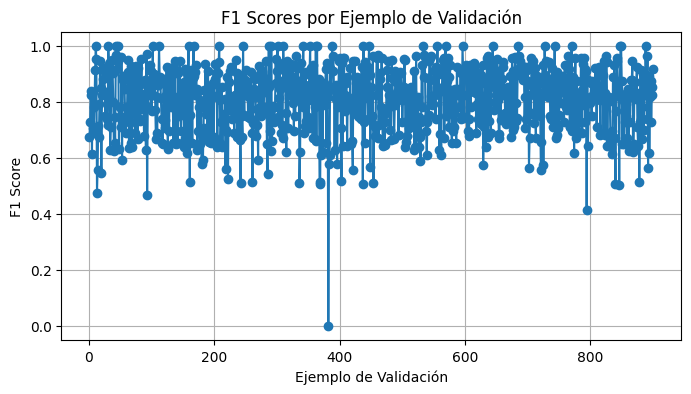

In [12]:
 # Resumen de resultados en test: ver histrograma de F1 scores
f1_scores = [r['f1_score'] for r in results]
plt.figure(figsize=(8, 4))
plt.plot(range(1, len(f1_scores) + 1), f1_scores, marker='o')
plt.title("F1 Scores por Ejemplo de Validación")
plt.xlabel("Ejemplo de Validación")
plt.ylabel("F1 Score")
plt.grid(True)
plt.show()

In [16]:
#results[0] # observar que hay

In [13]:
# Guardar CSV - resultados de validación
OUTPUT_DIR_VAL = os.path.join(OUTPUT_DIR, "result_validation")
os.makedirs(OUTPUT_DIR_VAL, exist_ok=True)
csv_path = os.path.join(OUTPUT_DIR_VAL, 'validation_results.csv')
with open(csv_path, 'w', encoding='utf-8', newline='') as f:
    writer = csv.DictWriter(f, fieldnames=['text','f1','raw','pred','true'], delimiter='|')
    writer.writeheader()
    for r in results:
        writer.writerow({
            'text': r['nat_language'],
            'f1': r['f1_score'],
            'raw': r['raw_prediction'],
            'pred': json.dumps(r['prediction'], ensure_ascii=False),
            'true': json.dumps(r['true_json'], ensure_ascii=False)
        })
print('CSV guardado en', csv_path)

CSV guardado en output/results/v08\result_validation\validation_results.csv


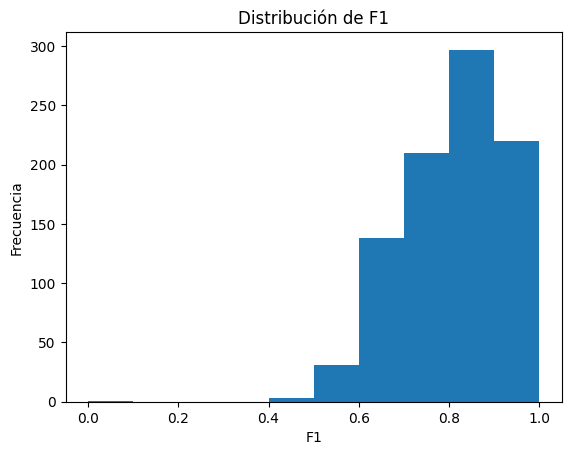

Histograma guardado en output/results/v08\f1_distribution.png


In [15]:
# Histograma F1
f1_scores = [r['f1_score'] for r in results]
plt.figure()
plt.hist(f1_scores, bins=10)
plt.title('Distribución de F1')
plt.xlabel('F1')
plt.ylabel('Frecuencia')
plt.savefig(os.path.join(OUTPUT_DIR, 'f1_distribution.png'))
plt.show()
plt.close()
print('Histograma guardado en', os.path.join(OUTPUT_DIR, 'f1_distribution.png'))

In [ ]:
# Mostrar peores 3 ejemplos
sorted_by_f1 = sorted(results, key=lambda x: x['f1_score'])
print('\nPeores 10 ejemplos:')
for r in sorted_by_f1[:10]:
    print(f"Ejemplo #{r['idx']} - F1 Score: {r['f1_score']}")
    print('Texto:', r['raw'])
    print("*"*90)
    print('Pred:', r['pred'])
    print('True:', r['true'])
    print('-'*150)

KeyError: 'f1'

In [ ]:
val_list[48]

In [ ]:
print(len(val_list))